In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import re
import os
from HelperFunctions import *

In [2]:
print(timestmp2sec(sec2timestmp(12)))
print(timestmp2sec("00:01:23"))

12.0
83.0


In [3]:
def getTripTimes(directory):
    dcuts = []
    trips = []
    drt_trips = []

    for root, subdirs, files in os.walk(directory):
            request = re.match(".*?(\d*\.?\d*)dcut$", root)
            if request:
                dcuts.append(float(request.group(1)))
                for roott, subdirss, filess in os.walk(root):
                    for file in filess:
                        if file == "output_trips.csv.gz":
                            df = pd.read_csv(
                                os.path.join(roott, file), sep=";", compression="gzip"
                            ).loc[:, ["person", "trav_time", "wait_time", "modes"]]
                            df["trav_time"] = df["trav_time"].apply(timestmp2sec)
                            df["wait_time"] = df["wait_time"].apply(timestmp2sec)
                            df.set_index("person", inplace=True)
                            trips.append(df)
                        if file == "0.drt_trips_drt.csv":
                            df = pd.read_csv(os.path.join(roott, file), sep=";").loc[
                                :, ["personId", "waitTime", "travelDistance_m", "direcTravelDistance_m"]
                            ]
                            drt_trips.append(df.groupby("personId").sum())

    return np.array(dcuts), trips, drt_trips

In [4]:
from matplotlib import cm
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

# Modes to analyze in here
modes = {
    "walk-drt-walk": 0,
    "walk-drt-walk-pt-walk-drt-walk": 1,
    "walk-drt-walk-pt-walk-pt-walk-drt-walk": 1,
}

color_map = cm.viridis(np.linspace(0, 1, len(modes)+1))

legend_elements = [
    Patch(color=color_map[0], label="DRT"),
    Patch(color=color_map[1], label="DRT-PT-DRT"),
#     Patch(color=color_map[2], label="drt-pt-pt-drt"),
    Patch(color=color_map[2], label="other"),
]


def plot_hist(df, g, ax=None):
    N = 24
    bins = np.linspace(0, 2500, N + 1)
    edges = (bins[1:] + bins[:-1]) / 2
    bar_width = bins[1] - bins[0]
    modes_array = np.zeros(
        (len(modes), N)
    )  # rows correpond to drt, drt-pt-drt, drt-pt-pt-drt & other
    for j in range(N):
        bin_df = df.loc[
            (df["pure_trav_time"] > bins[j]) & (df["pure_trav_time"] < bins[j + 1]),
            :,
        ]
        mode_count = bin_df.groupby("modes").count()["trav_time"]
        for key, item in mode_count.to_dict().items():
            if key in modes.keys():
                modes_array[modes[key], j] = item
            else:
                modes_array[len(modes)-1, j] += item
    bottoms = np.zeros(N)
    if ax == None:
        for j in range(modes_array.shape[0]):
            plt.bar(
                edges,
                modes_array[j],
                color=color_map[j],
                width=bar_width,
                bottom=bottoms,
            )
            bottoms += modes_array[j]
        plt.xlabel("time (s)")
        mean_v_line = plt.axvline(df["pure_trav_time"].mean(), ls="--", c="green", label="Mean")
        plt.title("$d_c$" + " = {}".format(g))
        new_legend = legend_elements + [mean_v_line]
        plt.legend(handles=new_legend)
    else:
        for j in range(modes_array.shape[0]):
            ax.bar(
                edges,
                modes_array[j],
                color=color_map[j],
                width=bar_width,
                bottom=bottoms,
            )
            bottoms += modes_array[j]
        ax.set_xlabel("time (s)")
        mean_v_line = ax.axvline(df["pure_trav_time"].mean(), ls="--", c="c", label="Mean")
        ax.set_title(r"$\zeta$" + " = {}".format(g))
        new_legend = legend_elements + [mean_v_line]
        return new_legend
#         ax.legend(handles=new_lgdel)

dcut:  0.0
Mean pure travel time:  503.84238 , formatted:  0:8:23
ratio of successfull trips:  1.0
Average wait time:  278.2941864767829
Pt in trip ratio:  0.95414
<Delta>:  2.216174046021841
-------

dcut:  100.0
Mean pure travel time:  503.84238 , formatted:  0:8:23
ratio of successfull trips:  1.0
Average wait time:  278.2941864767829
Pt in trip ratio:  0.95414
<Delta>:  2.216174046021841
-------

dcut:  200.0
Mean pure travel time:  503.11706 , formatted:  0:8:23
ratio of successfull trips:  1.0
Average wait time:  275.4791231210809
Pt in trip ratio:  0.95414
<Delta>:  2.211883088745121
-------

dcut:  300.0
Mean pure travel time:  500.16365 , formatted:  0:8:20
ratio of successfull trips:  1.0
Average wait time:  269.4285885729716
Pt in trip ratio:  0.95398
<Delta>:  2.1866340805241116
-------

dcut:  400.0
Mean pure travel time:  503.15087 , formatted:  0:8:23
ratio of successfull trips:  1.0
Average wait time:  275.64036763308695
Pt in trip ratio:  0.95281
<Delta>:  2.2154458433

/scratch01.local/hheuer/matsim-bimodal/python_analysis/env/lib/python3.7/site-packages/ipykernel_launcher.py:43: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


<Delta>:  2.0895124776084777
-------



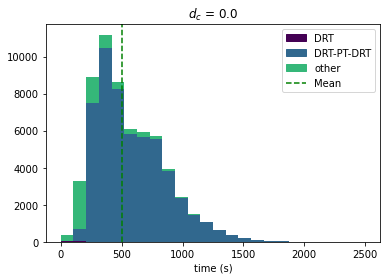

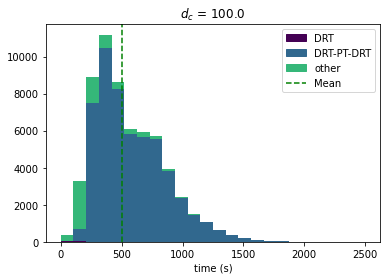

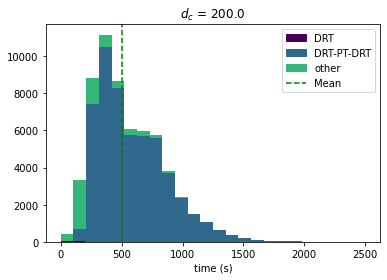

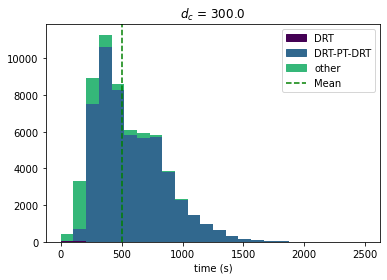

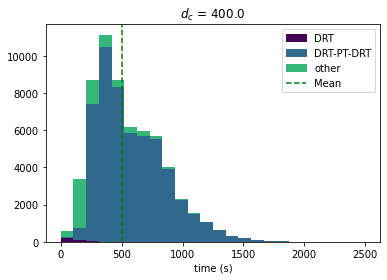

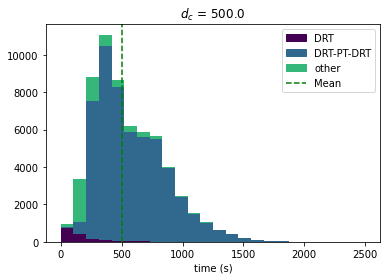

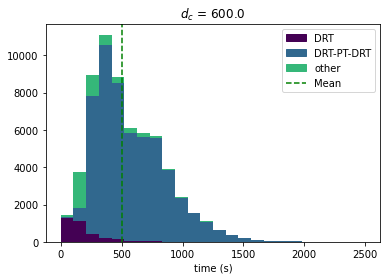

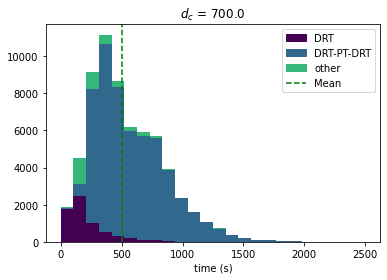

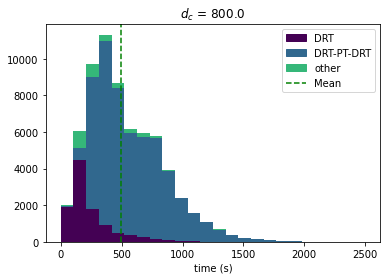

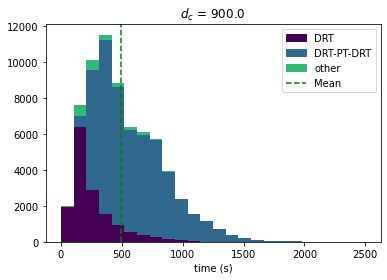

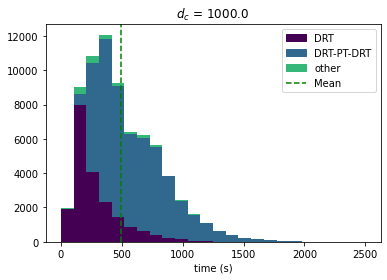

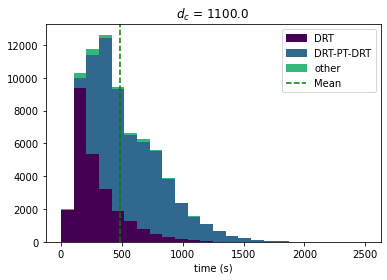

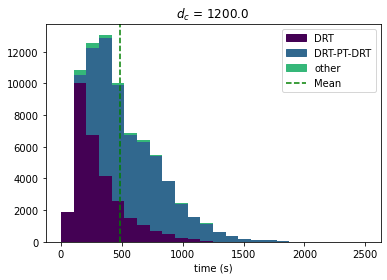

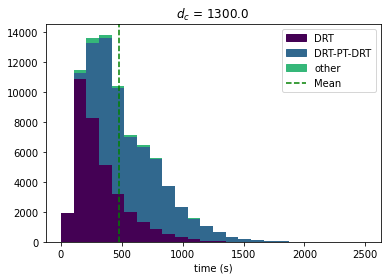

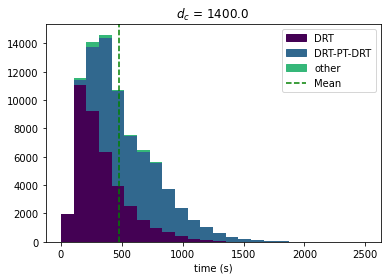

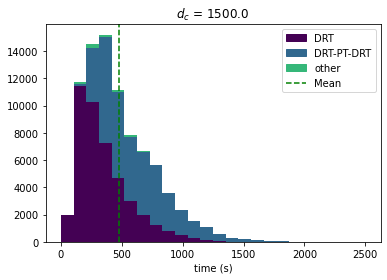

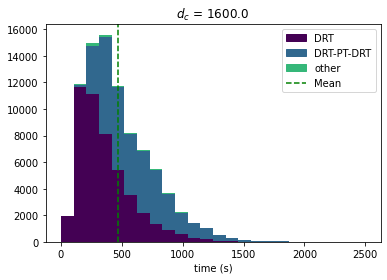

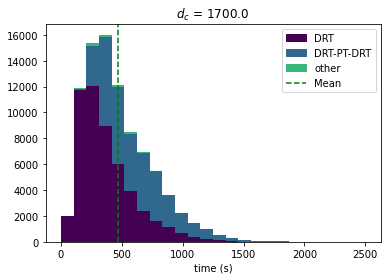

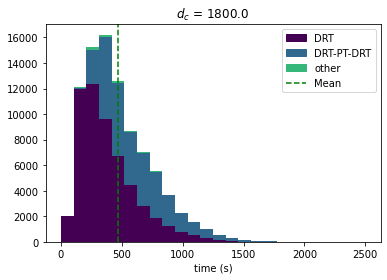

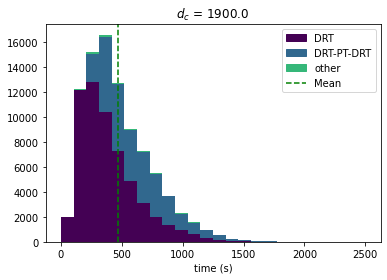

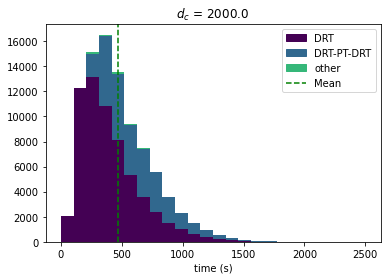

In [5]:
%matplotlib inline

# directory_bim = "/home/helge/Applications/matsim/matsim_results/OwnIntermodalAccEgr/ConvCrit/100000reqs/seed31357/bim_5minTransit_wDiag/"
# directory_bim = "/home/helge/Applications/matsim/matsim_results_ssd/PeriodicBC/8DrtCap/OwnIntermodalAccEgr/ConvCrit/bim2_15min_diag/"
directory_bim = "/home/helge/Applications/matsim/matsim_results_ssd/PeriodicBC/8DrtCap/OwnIntermodalAccEgr/ConvCrit/bim_15min_diag_ext/"
directory_bim = "/scratch01.local/hheuer/matsim-bimodal/scenarios/fine_grid/bimodal/output/CILocalEllipsesConvCrit/100000reqs/3000dist/1000drt"

N_trips = 100000

dcuts, trip_dfs, trip_drt_dfs = getTripTimes(directory_bim)

idx = np.argsort(dcuts)
dcuts = dcuts[idx]
trip_dfs = [trip_dfs[i] for i in idx]
trip_drt_dfs = [trip_drt_dfs[i] for i in idx]
mean_pure_tt_times = []

for i, dc in enumerate(dcuts):
    trip_dfs[i] = (
        trip_dfs[i]
        .groupby("person")
        .agg({"trav_time": np.sum, "wait_time": np.sum, "modes": combineModesSeriesStr})
    )
    print("dcut: ", dc)
    trip_dfs[i]["pure_trav_time"] = trip_dfs[i]["trav_time"] - trip_dfs[i]["wait_time"]
    #     trip_dfs[i]["pure_trav_time"] = (
    #         trip_dfs[i]["pure_trav_time"] + trip_drt_dfs[i]["waitTime"]
    #     )
    #     trip_dfs[i] = trip_dfs[i][trip_dfs[i]['pure_trav_time'] < 3600]
    mean_time = trip_dfs[i]["pure_trav_time"].mean()
    print(
        "Mean pure travel time: ", mean_time, ", formatted: ", sec2timestmp(mean_time)
    )
    mean_pure_tt_times.append(mean_time)
    print("ratio of successfull trips: ", len(trip_dfs[i]) / N_trips)
    print("Average wait time: ", trip_drt_dfs[i]["waitTime"].mean())
    mode_count = trip_dfs[i].groupby("modes").count()["trav_time"]
    print(
        "Pt in trip ratio: ",
        sum([count for key, count in mode_count.to_dict().items() if "pt" in key])
        / mode_count.sum(),
    )
    plt.figure()
    plot_hist(trip_dfs[i], dc)
    print("<Delta>: ", (trip_drt_dfs[i]["travelDistance_m"] / trip_drt_dfs[i]["direcTravelDistance_m"]).mean())
#     plt.savefig('RideTimeDist_zeta{}.png'.format(z))
    print("-------\n")

plt.show()

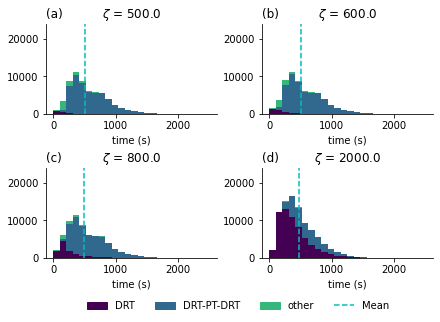

In [73]:
fig, axes = plt.subplots(2,2,constrained_layout=True)

j = 0
titles = ["(a)", "(b)", "(c)", "(d)",]
for i, dc in enumerate(dcuts):
    if dc==500 or dc==600 or dc==800 or dc==2000:
        handles = plot_hist(trip_dfs[i], dc, axes[j//2,j%2])
        axes[j//2,j%2].spines["top"].set_visible(False)
        axes[j//2,j%2].spines["right"].set_visible(False)
        axes[j//2,j%2].set_ylim((0,24000))
        axes[j//2,j%2].set_title(titles[j], loc="left")
#         axes[j//2,j%2].grid()
        j += 1

# lgd_ax = fig.add_subplot()
leg = fig.legend(handles=handles, loc=2, bbox_to_anchor=(0.17,-0.1,1,0.1), frameon=False, ncol=5)

# fig.savefig("output/RideTimeDistr.pgf", bbox_extra_artists=(leg,), bbox_inches="tight")
# fig.savefig("output/RideTimeDistr.pgf")
plt.show()

In [3]:
def zetaAnalytic(delta_av, u_v):
    beta = 0.383
    return 2*beta*delta_av/(delta_av-4/np.pi*u_v)

def deltaAv(b_av):
    delta_max = 1.5
    return np.exp(np.log(2*delta_max/3+1/(3*delta_max))/np.log(2)*np.log(2*b_av-1))
#     return np.exp(np.log(2*delta_max/3+1/(3*delta_max))/np.log(3)*np.log((2*b_av+1)/2))

def zetaAnalyticWithTramWait(delta_av, u, v, mu):
    beta = 0.383
    u_v = u/v
    return (2*beta*delta_av+u/mu)/(delta_av-4/np.pi*u_v)

print(zetaAnalytic(deltaAv(1.5), 1/2))
print(zetaAnalyticWithTramWait(deltaAv(2), 30, 60, 4))

1.5987334452829094
11.591827581165333


<IPython.core.display.Javascript object>


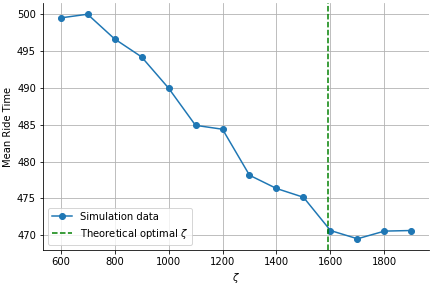

In [82]:
%matplotlib notebook
fig, ax = plt.subplots(constrained_layout=True)

ax.plot(dcuts[1:-1], mean_pure_tt_times[1:-1], 'o-', label='Simulation data')
# ax.axvline(zetaAnalytic(1.52, 1/2), ls='--', c='g', label=str('Theoretical optimal '+r'$\zeta$'))
ax.axvline(1.59*1000, ls='--', c='g', label=str('Theoretical optimal '+r'$\zeta$'))
ax.set_xlabel(r'$\zeta$')
ax.set_ylabel('Mean Ride Time')
ax.grid()
ax.legend()

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

# fig.savefig('OptimalZeta.pdf')
# fig.savefig('test.pdf')
# plt.show()

In [ ]:
path_occupancy = "/home/helge/Applications/matsim/matsim_results_ssd/PeriodicBC/8DrtCap/OwnIntermodalAccEgr/ConvCrit/bim_15min_diag_ext/zeta1.4/ITERS/it.0/0.drt_occupancy_time_profiles_drt.txt"

df_occ_drt = pd.read_csv(path_occupancy, sep="\t")
drt_occ, drt_deviation = getAverageOcc(df_occ_drt.drop(columns="time"), exclude_empty_vehicles=True)
print(drt_occ, drt_deviation)

In [ ]:
directory_drt = "/home/helge/Programs/matsim/matsim_results/OwnIntermodalAccEgr/ConvCrit/100000reqs/seed31357/drt_wDiag/gammaInfty/"
N_trips = 100000

drt_df = pd.read_csv(
    os.path.join(directory_drt, "output_trips.csv.gz"), sep=";", compression="gzip"
).loc[:, ["person", "trav_time", "wait_time", "modes"]]
drt_df["trav_time"] = drt_df["trav_time"].apply(timestmp2sec)
drt_df["wait_time"] = drt_df["wait_time"].apply(timestmp2sec)
drt_df["pure_trav_time"] = drt_df["trav_time"]  - drt_df['wait_time']
drt_df.set_index("person", inplace=True)

# drt_df2 = pd.read_csv('/home/helge/Programs/matsim/matsim_results/ConvCrit/115997reqs/drt/gammaInfty/ITERS/it.0/0.drt_trips_drt.csv', sep=';').loc[:,['personId', 'waitTime', 'travelTime']]
# drt_df2 = drt_df2.groupby('personId').sum()
# drt_df['pure_trav_time'] = drt_df['pure_trav_time'] + drt_df2['waitTime']

print("ratio of successfull trips: ", len(drt_df) / N_trips)
print("Mean pure travel time: ", drt_df["pure_trav_time"].mean())
print("Mean wait time: ", drt_df["wait_time"].mean())

# drt_df['pure_trav_time'].plot.hist(bins=24, range=(0, 3600), color=[cm.rainbow(c) for c in np.linspace(0,1,28)])
# bla = drt_df['pure_trav_time'].plot.hist(bins=24, range=(0, 3600), color=color_map)
plt.figure()
plot_hist(drt_df, r"$\infty$")
# plt.savefig('RideTimeDist_gammaInfty.png')
plt.show()

### Check if access/egress legs do have different waiting time distributions

In [ ]:
path = "/home/helge/Programs/matsim/matsim_results/OwnIntermodalAccEgr/100000reqs/seed31357/bim/gamma1_4/ITERS/it.0/0.drt_trips_drt.csv"
# path = "/home/helge/Programs/matsim/matsim_results/ConvCrit/115997reqs/seed42/bim_ext/gamma0_7/ITERS/it.0/0.drt_trips_drt.csv"

df = pd.read_csv(path, sep=';')
df = df.sort_values(['personId', 'arrivalTime'])
# mask = df[['personId','arrivalTime']].groupby('personId').count()==1
# df = df[df['personId'].isin(mask[~mask].dropna().index)]
# df_access = df.iloc[::2,:]
# df_egress = df.iloc[1::2,:]

plt.hist(df['waitTime'], range=(0,3600), bins=24)

plt.show()

In [ ]:
for i in range(24):
    plt.figure()
    plt.hist(
        df[(df["departureTime"] > i * 3600) & (df["departureTime"] < (i + 1) * 3600)][
            "waitTime"
        ],
        range=(0, 3600),
        bins=24,
    )
    plt.title("{} - {}".format(i,i+1))
# plt.hist(df['waitTime'], range=(0, 3600), bins=24)
# display(df[(df['waitTime'] > 0) & (df['waitTime']) < 150])

plt.show()